In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score

%matplotlib inline

C:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d



The Questions I would Like to answer are listed below:

 - Best ways to achieve the best price on AirBNB?
 - Best way to achieve good reviews?
 - Is it possile to make an accurate predictive model for listing price based on machine leraning

## Data gathering, assessing and cleaning

The next cells will contain datawrangling work


In [3]:
# Data gathering
# Import data into dataframes
calendar = pd.read_csv("./seattle/calendar.csv")
listings = pd.read_csv("./seattle/listings.csv")
reviews = pd.read_csv("./seattle/reviews.csv")

In [4]:
# Assessing
print("Size of dataframes, rows, columns \n", 
      "Calendar : ", calendar.shape, "\n",
      "Listings : ", listings.shape, "\n",
      "Reviews : ", reviews.shape,)

Size of dataframes, rows, columns 
 Calendar :  (1393570, 4) 
 Listings :  (3818, 92) 
 Reviews :  (84849, 6)


In [5]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

## Cleaning

In [6]:
# Create some extra features based on amenities
listings['TV'] = listings.amenities.str.contains("tv", case=False)
listings['Internet'] = listings.amenities.str.contains('internet|wireless', case=False)
listings['Parking'] = listings.amenities.str.contains('parking', case=False)
listings['Washer'] = listings.amenities.str.contains('washer', case=False)
listings['Dryer'] = listings.amenities.str.contains('dryer', case=False)
listings['AirCon'] = listings.amenities.str.contains('air condition|air conditioning', case=False)


#### Addressing missing values

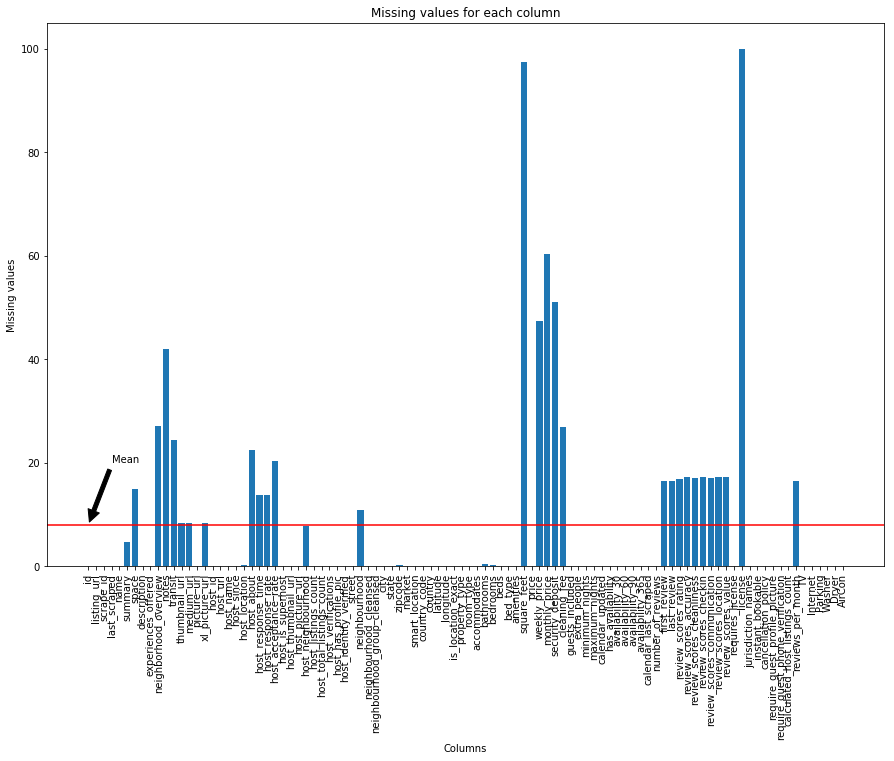

In [7]:
# Visualize missing values
# List comprehensions for headers and corresponding missing values where series has missing values
missing_percent = [(listings[series].isnull().sum()/len(listings[series]))*100 for series in list(listings) ]
headers_missing = [series for series in list(listings)  ]

mean = np.mean(missing_percent)
fig, ax = plt.pyplot.subplots(figsize=(15,10))
plt.pyplot.title("Missing values for each column")
plt.pyplot.xlabel("Columns")
plt.pyplot.ylabel("Missing values")
plt.pyplot.axhline(y=mean, c='r', label='"Mean"')

ax.annotate('Mean', xy=(0, mean), xytext=(3, 20),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.pyplot.bar(headers_missing, missing_percent)
plt.pyplot.xticks(rotation=90);


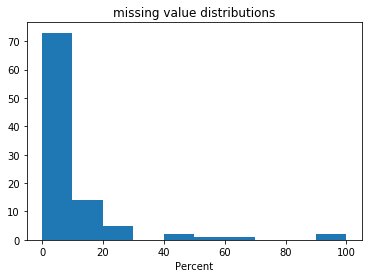

In [8]:
# Get a missingvalue distribution in order to set a cut-off point for missing values
plt.pyplot.title("missing value distributions")
plt.pyplot.xlabel("Percent")
plt.pyplot.hist(missing_percent);


### I decided to remove columns with 20 % missing values or more as they are clearly outliers in this dataset

In [9]:
# Remove outlier columns
def remove_outlier_col(df, thresh):
    """
    Function to identify outlier columns. 
    Takes dataframe and outlier threshold as input, returns two lists. 
    First list identifies the columns and the second contains coresponding number of missing values
    """
    outlier_columns = []
    outlier_value = []
    for i in list(df):
        if ((df[i].isnull().sum() / len(df[i])) > thresh):
           
            outlier_columns.append(i)
            outlier_value.append(df[i].isnull().sum())
        
    return outlier_columns, outlier_value

In [10]:
outlier_col, outlier_value = remove_outlier_col(listings, 0.2)

In [11]:
for i in zip(outlier_col, outlier_value):
    print(i)

('neighborhood_overview', 1032)
('notes', 1606)
('transit', 934)
('host_about', 859)
('host_acceptance_rate', 773)
('square_feet', 3721)
('weekly_price', 1809)
('monthly_price', 2301)
('security_deposit', 1952)
('cleaning_fee', 1030)
('license', 3818)


In [12]:
listings.drop(outlier_col, axis=1, inplace=True)

### Categorical features

In [13]:
#  Here I decided which columns to keep and which to drop
list(listings.select_dtypes(include=['object']))

['listing_url',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_response_time',
 'host_response_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'is_location_exact',
 'property_type',
 'room_type',
 'bed_type',
 'amenities',
 'price',
 'extra_people',
 'calendar_updated',
 'has_availability',
 'calendar_last_scraped',
 'first_review',
 'last_review',
 'requires_license',
 'jurisdiction_names',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

In [14]:
# I saw that scrape_id contains the same value for all rows and that host_listings_count is the same as host_total_listings_count
listings.drop(['scrape_id', 'host_listings_count'], axis=1, inplace=True)

In [15]:
# These are the features i decided to reencode and to make numeric out of the categorical features. 
# Decision is based on data distribution in each feature. whether another feature allready explains the same and how relevant i belive
# the feature is.

one_hot_encode = ['cancellation_policy', 'neighbourhood_group_cleansed', 'property_type', 'bed_type', 'host_identity_verified',
                  'host_response_time', 'host_is_superhost', 'room_type', 'instant_bookable']
    
make_numeric = ['host_response_rate', 'price', 'extra_people' ]    
    

In [16]:
# Convert to numeric values
listings.host_response_rate = listings.host_response_rate.str.replace("%", "")
listings.host_response_rate = pd.to_numeric(listings.host_response_rate)

listings.price = listings.price.str.replace("$", "")
listings.price = listings.price.str.replace(",", "")
listings.price = pd.to_numeric(listings.price)

listings.extra_people = listings.extra_people.str.replace("$", "")
listings.extra_people = pd.to_numeric(listings.extra_people);

In [17]:
list(listings.select_dtypes(include=['object']));

In [18]:
drop_num = ['id', 'host_id', 'latitude', 'longitude', 'review_scores_accuracy', 'review_scores_cleanliness',
            'review_scores_communication', 'review_scores_location', 'review_scores_checkin','review_scores_value', 
            'reviews_per_month', 'calculated_host_listings_count']

drop_object = [i for i in list(listings.select_dtypes(include=['object'])) if i not in make_numeric + one_hot_encode]

In [19]:
listings.drop(drop_num + drop_object, axis=1, inplace=True)

highly skewed distributions and several redundant features within the dataset led me to drop all features in drop_num


In [20]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 32 columns):
host_response_time              3295 non-null object
host_response_rate              3295 non-null float64
host_is_superhost               3816 non-null object
host_total_listings_count       3816 non-null float64
host_identity_verified          3816 non-null object
neighbourhood_group_cleansed    3818 non-null object
property_type                   3817 non-null object
room_type                       3818 non-null object
accommodates                    3818 non-null int64
bathrooms                       3802 non-null float64
bedrooms                        3812 non-null float64
beds                            3817 non-null float64
bed_type                        3818 non-null object
price                           3818 non-null float64
guests_included                 3818 non-null int64
extra_people                    3818 non-null float64
minimum_nights                  3818 non

### Visualizing correlations through heatmap

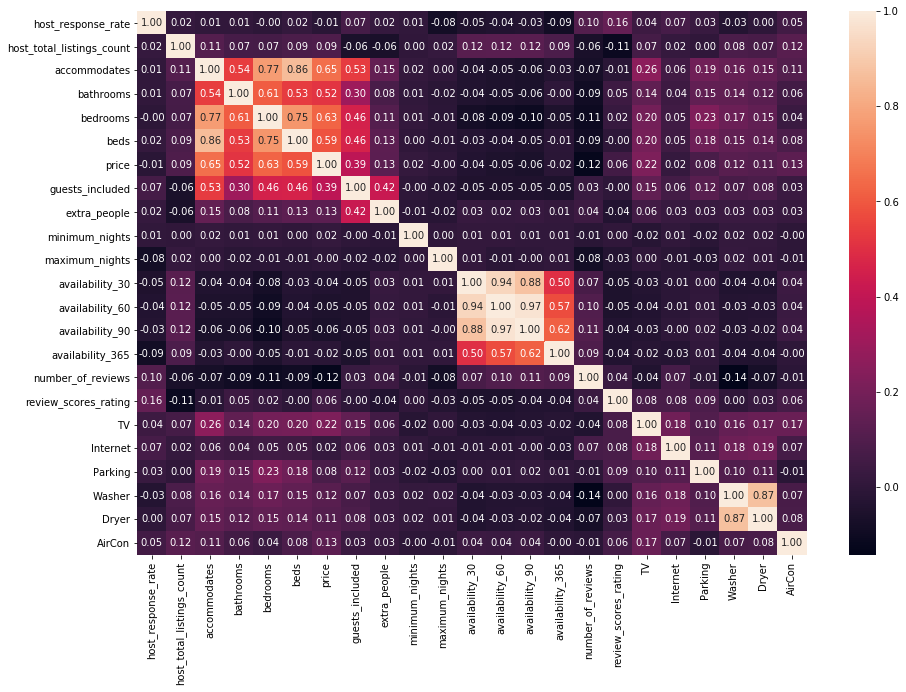

In [21]:
fig, ax = plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');


As we can see in the heatmap, some of these features correlate very high. I have decided to drop features that correlate more than 60 % with another in order to make sure that the features I keep are independent of eachother. Its also clear that beds and bedrooms are latent features of "accommodates"


In [22]:
highcorr = ['beds', 'bedrooms', 'availability_60', 'availability_90', 'availability_365', 'Dryer']

listings.drop(highcorr, axis=1, inplace=True)

I saw that the "Accommodates" feature was highly correlated with price but it seems to be some outlier datapoints in this feature. 1 listing can accommodate 11 people and the price ( 1000 $ ) is by far the highets of them all. I therfore decided to only keep rows with accommodation upto 8 people

''

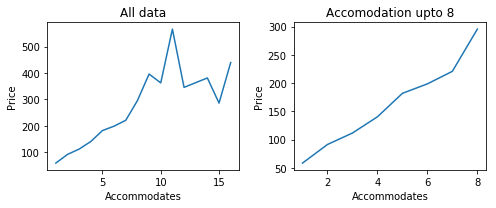

In [23]:
accom = pd.DataFrame(listings.groupby("accommodates")['price'].mean(), columns=['price'])

f,a = plt.pyplot.subplots(figsize=(7,3))
plt.pyplot.subplot(1,2,1)
plt.pyplot.title("All data")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accom)

plt.pyplot.subplot(1,2,2)
plt.pyplot.title("Accomodation upto 8")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accom[:8])

plt.pyplot.tight_layout()
;


In [24]:
# Drop listings that can accommodate more than 8 people as its very noisy 
listings = listings[listings.accommodates <= 8]

### New Heatmap

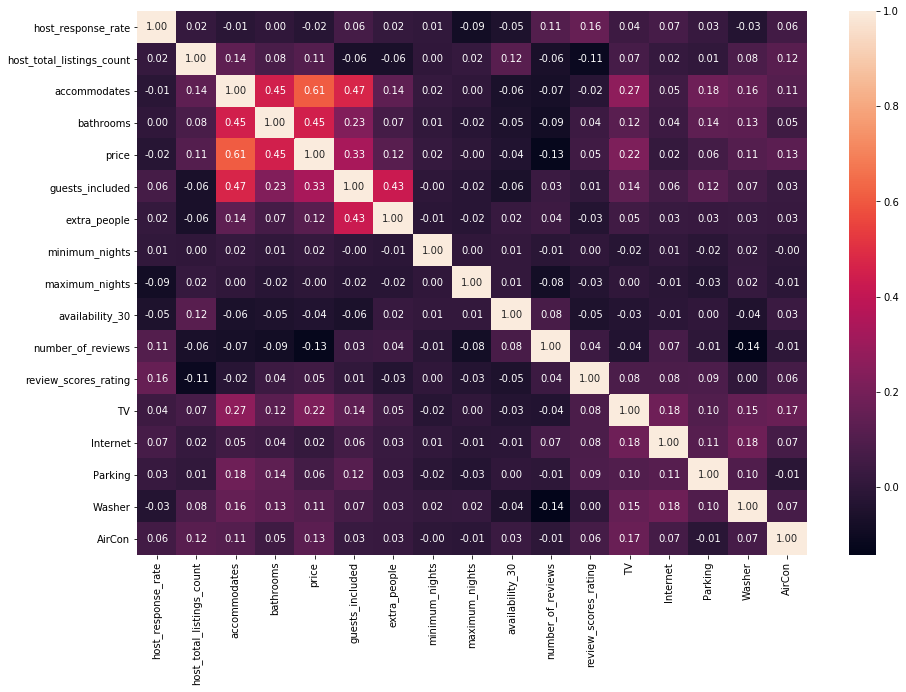

In [25]:
fig, ax = plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');

The heatmap only contains numerical data. I will also look at location in the next part with descriptive statistics

In [26]:
# Mean listings price per neigbourhood
hood = pd.DataFrame(listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False))
hood['data_points'] = listings.neighbourhood_group_cleansed.value_counts()
hood

,price,data_points
neighbourhood_group_cleansed,,
Magnolia,166.600000,55
Downtown,152.388258,528
Queen Anne,149.314879,289
Cascade,140.101124,89
West Seattle,138.181818,198
Central Area,123.047222,360
Capitol Hill,122.230631,555
Ballard,118.964444,225
Other neighborhoods,117.512723,786


## Question 1: How to get the best price

We can see from the relationship heatmap aswell as the "accommodates vs price" outline that the fundamental driver for cost is what number of individuals can be accomadated.  
.The other less significant feauttures or latent features are number of bedrooms, beds, bathrooms and guests  From the cell above we can likewise observe that the normal cost for shifts alot for various neighborhoods. Magnolia, Downtown and Queen Anne are the three most costly zones, while 
Northgate, University District and Delridge are the least expensive ones.  TV, web, clothes washer and air con are likewise imperative. 

## Question 2: How to achive better reviews?

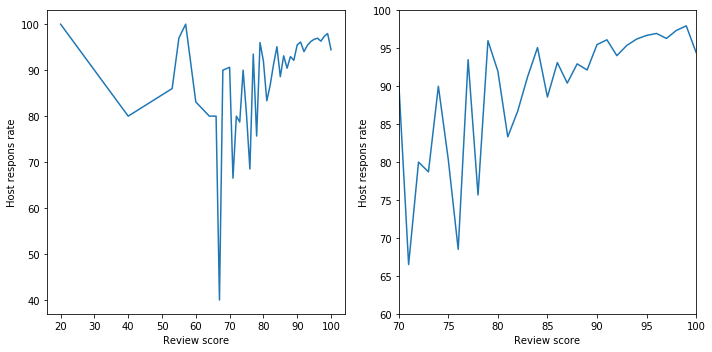

In [27]:
# visulizing the relationship between resonse rate and review score
host = pd.DataFrame(listings.groupby('review_scores_rating')['host_response_rate'].mean())
plt.pyplot.subplots(figsize=(10,5))
plt.pyplot.title("Response rate vs review score")
plt.pyplot.subplot(1,2,1)
plt.pyplot.plot(host)
plt.pyplot.ylabel("Host respons rate")
plt.pyplot.xlabel("Review score")

# data under 70 for review score seems noisy so i made a subplot for datapoints above
plt.pyplot.subplot(1,2,2)
plt.pyplot.plot(host)
plt.pyplot.ylabel("Host respons rate")
plt.pyplot.xlabel("Review score")
plt.pyplot.xlim(70,100)
plt.pyplot.ylim(60,100)

plt.pyplot.tight_layout()


From the relationship heatmap we can see that the most vital factor for getting great reviews is to react on all demands that visitors have(host reaction rate), which isnt excessively astounding. 

It likewise appears that has with numerous postings deteriorates reviews than the individuals who have 1 or few. One could feel that having numerous postings could infer a more regrettable reaction rate due the expanded measure of asks, however there is a little connection between's reaction rate and postings tally. I dont have information also bolster this hypothesis, however I believe that postings by hosts with numerous different postings are seen as basic and sterile with spotlight on expanding monetary benefits while postings from individuals who live in a similar appartment are seen as increasingly comfortable and warm. 

There is a little connection between's restrooms, cost and review score. I believe this is because of standard. Higher standard postings show signs of improvement audits. confinements on greatest evenings are awful for survey score and availability is significant. 

So to get the best reviews, you should: 

Not have an excessive number of postings 

React on each inquery you get 

Dont have constraints on evenings to remain 

incorporate amenities like parking spot, TV and Internet 

High availability (this one you may ignore on the off chance that you need to profit :) ) 

There is a negative connection to number of audits which is presumably because of some awful surveys for most postings that has been checked on. 

So the response to the inquiry is that you ought to suit whatever number individuals as would be prudent so as to get the best cost on AirBNB. The postings should be in the correct zone and its likewise critical to get great audits however not as imperative as to oblige whatever number as could be expected under the circumstances. having a TV and a parking space is additionally adviced aswell as a washer and ac.



# Predicting listing price with machine learning

In [60]:
# One hot encode categorical features before machine learning
listings_ohe = pd.get_dummies(listings, drop_first=True);

I needed to explore different avenues regarding diverse methods for treating missing qualities, I made 1 dataset where all Nans 

was simply dropped and another with imputation. 

I attempted both imputation by mean and I had a go at replacing NaN's with the most continuous component in every section. 

The upside of imputation is that I would not need to drop as much information, but rather the drawback is that it can truly intensify .

slants in the information that probably won't be right. Here i found dropping made more sense than imputating

In [61]:
# Split dataset into subsets for different handling of missing values
full_df = listings_ohe.dropna().copy()

imputed_df = listings_ohe.copy()
for col in imputed_df:
    imputed_df[col].fillna(imputed_df[col].value_counts().index[0], inplace=True)
  


In [62]:
# Length of each dataset
print("Length full_df : ", len(full_df),
      "Length of imputed_df : ", len(imputed_df))

Length full_df :  2794 Length of imputed_df :  3753


In [63]:
# Split into targets and features
target = full_df.price.copy()
features = full_df.drop('price', axis=1).copy()

target_imp = imputed_df.price.copy()
features_imp = imputed_df.drop('price', axis=1).copy()

In [64]:
# Split to training set and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(features_imp, target_imp, test_size=0.25)

## ADAboost

In [354]:
param_dist = {
 'n_estimators': [500, 2000],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }



adamodel = RandomizedSearchCV(AdaBoostRegressor(), param_distributions = param_dist, cv=3, n_iter = 20, n_jobs=-1);
                              
adamodel.fit(X_train, y_train)


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [500, 2000], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'loss': ['linear', 'square', 'exponential']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [355]:
y_pred = adamodel.predict(X_test_imp)

In [356]:
r2_score(y_test, y_pred)

0.40381211102599324

#### R2 scores for AdaBoost
- full_df: 0.44
- imputed_df : 0.40    

## SVM

SVM requires normalization of the data in order to get good results. If not some features will be given more weights than others. I used standardscaler to make sure all features gets evaluated equally

In [82]:
scaler = preprocessing.StandardScaler()

scaled_x = scaler.fit_transform(X_train)
test_x = scaler.transform(X_test)
scaled_x_imp = scaler.fit_transform(X_train_imp)
test_x_imp = scaler.transform(X_test_imp)

In [86]:
param_dist_svm = {
 'kernel': ['linear', 'rbf', 'poly'],
 'C' : [0.001,0.05,0.1]

 }

svmmodel = GridSearchCV(svm.SVC(), param_grid=param_dist_svm )
svmmodel.fit(scaled_x_imp, y_train_imp)

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf', 'poly'], 'C': [0.001, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [87]:
svmpred = svmmodel.predict(test_x_imp)
r2_score(y_test_imp, svmpred)

0.39011210839752497

#### R2 scores for SVM
- full_df: 0.50
- imputed_df : 0.39


# Randomforest

In [65]:
from scipy.stats import randint
# specify parameters and distributions to sample from
param_dist = {"max_depth": randint(3,15),
              "n_estimators" : [100, 1000],
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "min_samples_leaf" : randint(1,10)
                            }
n_iter_search = 20
randommodel = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)
randommodel.fit(X_train_imp, y_train_imp);

In [66]:
pred = randommodel.predict(X_test_imp)

In [67]:
r2_score(y_test_imp, pred)

0.5264372918731905

#### R2 scores for RandomForest
- full_df: 0.60
- imputed_df : 0.56  


### Conclusion 

The best model was Random Forest. It completed a few investigations on imputation on the missing information, including and expelling highlights and various hyper tuning methods . Random Forest ended up as the winner without fail. Its best gauge was a r2 score of 0.65 which implies that the model can clarify 65% of the variance in cost. The dataset contains little data about standard other than comforts, and I trust that a considerable measure of the unexplained variance of cost is identified with standard.